In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch.nn.init as init
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from icecream import ic


from torch_scatter import scatter_mean
from torch_geometric.data import Data
from torch.utils.data import Dataset

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import random

from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import os


######################################################################################################### 
####                                            Arguments                                           #####
######################################################################################################### 

import wandb 

In [3]:
# Replace argparse with a dictionary
args = {

    "seed": 42, 

    
    'dataset_transform': [],  # Example list of transformations
    'numbers_list': [0, 1, 3, 4, 5, 6, 7],  # List of integers for class selection
    'N': 5,  # Number of distinct training images per class
    'supervision_label_val': 10,  # An integer value for supervision

    # -----graph-----
    'num_internal_nodes': 500,  # Number of internal nodes
    'graph_type': 'stochastic_block',  # fully_connected_w_self  |  Type of graph fully_connected

    # -----model-----
    "normalize_msg": False, 
    'model_type': 'PC',  # Predictive model type
    'weight_init': 0.001,  # Weight initialization
    'T': 40,  # Number of iterations for gradient descent
    'lr_values': 0.01,  # Learning rate for values
    'lr_weights': 0.0001,  # Learning rate for weights
    'activation_func': 'swish',  # Activation function

    # -----learning-----
    'epochs': 5,  # Number of epochs
    'batch_size': 1,  # Batch size
    'seed': 42,  # Random seed
    'optimizer': False,  # Optimizer, can be True with a float value

    # -----logging-----
    'use_wandb': 'disabled',  # Wandb mode
}

# Access the arguments just like you would with argparse
print(args['dataset_transform'])  # Example of accessing an argument


[]


In [4]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)


# Create an object from the dictionary
args = Args(**args)


In [5]:
args.batch_size

1

In [6]:
import sys
sys.path.append(os.path.abspath("../scr"))


# Using argparse values
torch.manual_seed(args.seed)

generator_seed = torch.Generator()
generator_seed.manual_seed(args.seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Seed used", args.seed)
if torch.cuda.is_available():
    print("Device name: ", torch.cuda.get_device_name(0))


import torchvision.transforms as transforms
import numpy as np


transform_list = [
    transforms.ToTensor()
]

if args.dataset_transform:

    if "normalize_min1_plus1" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.5,), (0.5,)))

    if "normalize_mnist_mean_std" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    
    if "random_rotation" in args.dataset_transform:
        transform_list.append(transforms.RandomRotation(degrees=20))
    

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


######################################################################################################### 
####                                            Dataset                                             #####
######################################################################################################### 


## Subset of the dataset (for faster development)
# subset_size = 100  # Number of samples to use from the training set
# indices = list(range(len(mnist_trainset)))
# random.shuffle(indices)
# subset_indices = indices[:subset_size]

# mnist_train_subset = torch.utils.data.Subset(mnist_trainset, subset_indices)
# print("USSSSSING SUBSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEET")

# CustomGraphDataset params
dataset_params = {
    "mnist_dataset":            mnist_trainset,
    # "mnist_dataset":            mnist_train_subset,
    "supervised_learning":      True,
    "numbers_list":             args.numbers_list,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "N":                        args.N,     # taking the first n instances of each digit or use "all"

    "edge_index":               None,
    "supervision_label_val":    args.supervision_label_val,         # Strength of label signal within the graph. MNIST ~0-1, label_vector[label] = self.supervision_label_val
} 

from graphbuilder import graph_type_options

# Define the graph type
# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": args.num_internal_nodes,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": 

      {    
        "name": args.graph_type, # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
        "params": graph_type_options[args.graph_type]["params"]
      },      
  
}

if graph_params["graph_type"]["name"] == "stochastic_block":
  assert graph_params["internal_nodes"] == (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

from dataset import CustomGraphDataset

# Initialize the GraphBuilder
custom_dataset_train = CustomGraphDataset(graph_params, **dataset_params)

dataset_params["batch_size"] = args.batch_size
dataset_params["NUM_INTERNAL_NODES"] = graph_params["internal_nodes"]
# dataset_params["NUM_INTERNAL_NODES"] = (custom_dataset_train.NUM_INTERNAL_NODES)

print("Device \t\t\t:", device)
print("SUPERVISED on/off \t", dataset_params["supervised_learning"])


from helper.plot import plot_adj_matrix

single_graph = custom_dataset_train.edge_index


print("--------------Init DataLoader --------------------")
train_loader = DataLoader(custom_dataset_train, 
                          batch_size=dataset_params["batch_size"], 
                          shuffle=True, 
                          generator=generator_seed,
                          num_workers=1
                          )




NUM_SENSORY = 28*28  # 10

## TODO: FIX HOW TO DO THIS 
#### ---------------------------------------------------------------------------------------------------------------
# sensory_indices    = range(NUM_SENSORY)
# internal_indices   = range(NUM_SENSORY, NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"])
# num_vertices = NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"]  # Number of nodes in the graph
# supervision_indices = None

# if dataset_params["supervised_learning"]:
#     label_indices     = range(NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"], NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"] + 10)
#     supervision_indices = label_indices
#     num_vertices += 10

# print("sensory_indices\t\t:", len(sensory_indices), sensory_indices[0], "...", sensory_indices[-1])
# print("internal_indices\t:", len(internal_indices), internal_indices[0], "...", internal_indices[-1])
# print("num_vertices \t\t:", num_vertices)

# if dataset_params["supervised_learning"]:
#   assert num_vertices == len(sensory_indices) + len(internal_indices) + 10, "Number of vertices must match the sum of sensory and internal indices + labels"
# else:
#   assert num_vertices == len(sensory_indices) + len(internal_indices), "Number of vertices must match the sum of sensory and internal indices"
#### ---------------------------------------------------------------------------------------------------------------

num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices



print(train_loader.batch_size)
for batch, clean_image in train_loader:
    
    values, errors, predictions = batch.x[:, 0], batch.x[:, 1], batch.x[:, 2]
  
    x, edge_index, y, edge_weight = batch.x, batch.edge_index, batch.y, batch.edge_attr
    print("edge_index", edge_index.shape)

    print(batch.x[:, 0].shape)
    print(custom_dataset_train.edge_index.shape)
    

    full_batch = edge_index

    break




######################################################################################################### 
####                                            VALIDATION                                          #####
######################################################################################################### 
 
# from helper.validate_MP import validate_messagePassing
# validate_messagePassing()

######################################################################################################### 
####                                            FIND OPTIMAL LR                                     #####
######################################################################################################### 
""" 
SKIPPING FOR NOW, see local  
"""



######################################################################################################### 
####                                              Model  (setup)                                    #####
######################################################################################################### 

# lr_gamma, lr_alpha =  (0.1 ,  0.0001)
# lr_gamma, lr_alpha =  (0.1, 0.00001)


model_params = {
    
    'num_vertices': num_vertices,
    'sensory_indices': (sensory_indices), 
    'internal_indices': (internal_indices), 
    "supervised_learning": (supervision_indices),

    "lr_params": (args.lr_values, args.lr_weights),
    #   (args.lr_gamma, args.lr_alpha), 
    "T": args.T,
    "graph_structure": custom_dataset_train.edge_index_tensor, 
    "batch_size": train_loader.batch_size, 
    "use_learning_optimizer": args.optimizer if not args.optimizer  else [args.optimizer],    # False or [0], [(weight_decay=)]
    
    # "weight_init": "uniform",   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "weight_init": args.weight_init,   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "activation": args.activation_func,  
    "clamping": None , # (0, torch.inf) or 'None' 

    "normalize_msg": args.normalize_msg,
 }

# 

learning_params = model_params.copy()
learning_params['sensory_indices'] = list(learning_params['sensory_indices'])
learning_params['internal_indices'] = list(learning_params['internal_indices'])
learning_params['supervised_learning'] = list(learning_params['supervised_learning'])
# learning_params['transform'] = transform.to_dict()["transform"]
learning_params['dataset_transform'] = args.dataset_transform

learning_params['graph_structure'] = (learning_params['graph_structure']).cpu().numpy().tolist()

model_params_name = f"num_internal_nodes_{args.num_internal_nodes}_T_{args.T}_lr_weights_{args.lr_weights}_lr_values_{args.lr_values}_batch_size_{train_loader.batch_size}"

def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    
    raise TypeError('Unknown type:', type(obj))

# combi of learning params and dataset params
params_dict = {**dataset_params, **learning_params}


import json

from datetime import datetime




save_model_params = False

GRAPH_TYPE = graph_params["graph_type"]["name"]    #"fully_connected"
# GRAPH_TYPE = "test"    #"fully_connected"

date_hour = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

model_dir = f"trained_models/test/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"
# model_dir = f"trained_models/{args.model_type.lower()}/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"

# Define the directory path
print("Saving model, params, graph_structure to :", model_dir)

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# For saving, validation, re-creation 
os.makedirs(os.path.join(model_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "parameter_info"), exist_ok=True)

# For testing the model
os.makedirs(os.path.join(model_dir, "eval"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/generation"), exist_ok=True)
# os.makedirs(os.path.join(model_dir, "reconstruction"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/classification"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/denoise"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/occlusion"), exist_ok=True)

# Monitor during training
os.makedirs(os.path.join(model_dir, "energy"), exist_ok=True)

plot_adj_matrix(single_graph, model_dir, 
                node_types=(sensory_indices, internal_indices, supervision_indices))
plot_adj_matrix(full_batch, model_dir, node_types=None)





Using device: cuda
Seed used 42
Device name:  NVIDIA GeForce MX130
Supervised learning
Taking first n=5 digits from each class
--------Init base indices for sensory, internal, supervision nodes--------
--------Updating base indices for sensory, internal, supervision nodes--------
50 10 500
Creating Stochastic Block Model graph
self.edge_index torch.Size([2, 105977])
-----Done-----
1294
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 

In [7]:
import wandb 

run = wandb.init(
    mode=args.use_wandb,
    # entity="Erencan Tatar", 
    project=f"PredCod",
    name=f"T_{args.T}_lr_value_{args.lr_values}_lr_weights_{args.lr_weights}_",
    id=f"{model_params_name}_{date_hour}",
    # tags= 
    dir=model_dir,
    

    # tags=["param_search", str(model_params["weight_init"]), model_params["activation"],  *learning_params['dataset_transform']], 
    # Track hyperparameters and run metadata
    config={
        "supervised_learning": (graph_params["supervised_learning"]),

        "lr_params": (args.lr_values, args.lr_weights), 
        "T": args.T,

        "graph_structure": args.graph_type, 
        "model_type": args.model_type.lower(), 
        # "graph_structure": custom_dataset_train.edge_index_tensor, 
        # "include_self_connections": dataset_params['include_self_connections'],
        "batch_size": train_loader.batch_size, 
        "use_learning_optimizer": model_params["use_learning_optimizer"],    # False or [0], [(weight_decay=)]
        "weight_init":  model_params["weight_init"],   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
        "activation":  model_params["activation"],  
        "clamping": model_params["clamping"], # (0, torch.inf) or 'None' 

        "numbers_list":         dataset_params["numbers_list"],    
        "N":                    dataset_params['N'],     # taking the first n instances of each digit or use "all"

        "transform": learning_params['dataset_transform'],
    },
)

# Contains graph edge matrix and other parameters so quite big to open.
if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_full.txt", 'w') as file:
        json.dump(params_dict, file, default=default)
    print('Done')

# Store the exact command-line arguments in a text file
import sys
command = ' '.join(sys.argv)
with open(model_dir +'parameter_info/command_log.txt', 'w') as f:
    f.write(command)

with open('trained_models/current_running.txt', 'w') as f:
    f.write(model_dir)

# Save the (small) dictionary to a text file
params_dict_small = {}
keys_to_copy = ['supervised_learning', 'numbers_list', 'NUM_INTERNAL_NODES',  
                'N',  'batch_size','use_learning_optimizer', 'weight_init', 'activation', ]
# copy value from params_dict to params_dict_small
for key in keys_to_copy:
    params_dict_small[key] = params_dict[key]

if "dataset_transform" in params_dict:
    params_dict_small["dataset_transform"] = params_dict["dataset_transform"]


if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_small.txt", 'w') as file:
        json.dump(params_dict_small, file, default=default)
    print('Done')

print(f"Using batch size of \t: {train_loader.batch_size}")
print("Device \t\t\t:",          device)
print("Model type \t\t:", args.model_type.lower())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using batch size of 	: 1
Device 			: cuda
Model type 		: pc


In [8]:
batch

DataBatch(x=[1294, 3, 1], edge_index=[2, 105977], edge_attr=[105977], y=[1], batch=[1294], ptr=[2])

In [18]:

if args.model_type.lower() == "pc":
        
    from models.PC import PCGNN

    model = PCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)

    print("-----------Loading PC model-----------")

if args.model_type.lower() == "ipc":
        
    from models.IPC import IPCGNN

    model = IPCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)
    print("-----------Loading IPC model-----------")

# Magic
wandb.watch(model, 
            log="all",   # (str) One of "gradients", "parameters", "all", or None
            log_freq=10)


from helper.plot import plot_model_weights


save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch0.png')
# plot_model_weights(model, save_path)




######################################################################################################### 
####                                              Model  (training)                                 #####
######################################################################################################### 

model.pc_conv1.set_mode("training")

------------------------------------
gradients_minus_1: x and w.grad += 1 * grad
------------------------------------
VAL VS K 0.001 0.02779923608748833
-------------initialize--------------
-------------Activation func set to swish--------------
-----------Loading PC model-----------
vertix 1294
before after 784 784
before after 500 500
before after 10 10
-------------mode training--------------
-------------task None--------------


In [15]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [20]:

import time 
torch.cuda.empty_cache()

print(model)      

model = model.to(device)
# assert train_loader.batch_size == 1
print(len(train_loader))
print("Starting training")


# Initialize early stopping and history
earlystop = False
history = {
    "internal_energy_per_epoch": [],
    "sensory_energy_per_epoch": [],
}

# Define the early stopping threshold and OOM warning
threshold_earlystop = 0.05
max_energy_threshold = 1e6

start_time = time.time()

for epoch in range(args.epochs):
# for epoch in range(1):
    total_loss = 0
    last_loss = 1e10

    if earlystop:
        break

    for idx, (batch, clean) in enumerate(train_loader):
        torch.cuda.empty_cache()
        
        try:
            print("Label:", batch.y, "Input Shape:", batch.x.shape)
            model.train()
            # model.pc_conv1.restart_activity()

            batch = batch.to(device)
            history_epoch = model.learning(batch)

            # Append energy values to history
            history["internal_energy_per_epoch"].append(history_epoch["internal_energy_mean"])
            history["sensory_energy_per_epoch"].append(history_epoch["sensory_energy_mean"])

            model.pc_conv1.restart_activity()

            print(f"------------------ Epoch {epoch}: Batch {idx} ------------------")

            # Periodic checkpoint saving and plotting


            # Early stopping based on loss change
            if abs(last_loss - history_epoch["internal_energy_mean"]) < threshold_earlystop:
                earlystop = True
                print(f"EARLY STOPPED at epoch {epoch}")
                print(f"Last Loss: {last_loss}, Current Loss: {history_epoch['internal_energy_mean']}")
                break

            # Early stopping based on high energy
            if history_epoch["internal_energy_mean"] > max_energy_threshold:
                print("energy :", history_epoch["internal_energy_mean"])
                print("Energy too high, stopping training")
                earlystop = True
                break

            if idx >= 10:
                print("Epoch checkpoint reached, saving model...")

                # model_filename = f"model_state_dict_{epoch}.pth"
                # model_path = os.path.join(model_dir, model_filename)
                # torch.save(model.state_dict(), model_path)


                from helper.plot import plot_energy_during_training

                plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=model_dir,
                                            epoch=epoch)

                break 


        
        except RuntimeError as e:
            
            if 'out of memory' in str(e):
                print('WARNING: CUDA ran out of memory, skipping batch...')
                torch.cuda.empty_cache()
                continue
            else:
                torch.cuda.empty_cache()
                raise e

    print(f"Epoch {epoch} / {args.epochs} completed")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds for {args.epochs} epochs")


# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
# plot_model_weights(model, save_path)

if earlystop:
    print("Stopping program-------")
    # Open the file in write mode
    with open(model_dir + "early_stopped_training.txt", 'w') as file:
        # Write each list to the file

        file.write("Stopped training :\n")
    exit()


PCGNN(
  (pc_conv1): PCGraphConv(
    (prediction_mp): PredictionMessagePassing()
    (values_mp): ValueMessagePassing()
  )
)
42242
Starting training
Done for idx 32560
Done for idx 17786
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 3 / 40 {'internal_energy': 72.2667007446289, 'supervised_energy': 49.802154541015625, 'sensory_energy': 25.65299415588379},:   0%|          | 0/40 [00:00<?, ?it/s] 

Done for idx 20993


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9867, device='cuda:0') tensor(0.1789, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1243, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 3
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 0 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 75.72747802734375, 'supervised_energy': 49.837955474853516, 'sensory_energy': 54.268768310546875},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 22744


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9891, device='cuda:0') tensor(0.2308, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1628, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 4
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 1 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 75.2364273071289, 'supervised_energy': 49.83871078491211, 'sensory_energy': 52.261383056640625},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 42231


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9892, device='cuda:0') tensor(0.2219, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1569, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 5
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 2 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 73.96781921386719, 'supervised_energy': 49.78934860229492, 'sensory_energy': 70.22578430175781},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 7032


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9857, device='cuda:0') tensor(0.2531, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1802, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 6
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 3 ------------------
Label: tensor([7]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 77.62640380859375, 'supervised_energy': 49.87602996826172, 'sensory_energy': 40.1728515625},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 33508


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9917, device='cuda:0') tensor(0.2052, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1443, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 7
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 4 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 74.30632019042969, 'supervised_energy': 49.8477668762207, 'sensory_energy': 24.274150848388672},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 21746

Total energy at time 2 / 40 {'internal_energy': 72.9319076538086, 'supervised_energy': 49.849388122558594, 'sensory_energy': 24.282798767089844},:   0%|          | 0/40 [00:00<?, ?it/s]

-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9897, device='cuda:0') tensor(0.1725, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1204, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 8
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 5 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 74.61512756347656, 'supervised_energy': 49.752967834472656, 'sensory_energy': 27.530025482177734},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 5170

Total energy at time 2 / 40 {'internal_energy': 73.24200439453125, 'supervised_energy': 49.75566864013672, 'sensory_energy': 27.541893005371094},:   0%|          | 0/40 [00:00<?, ?it/s] 

-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9836, device='cuda:0') tensor(0.1850, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1286, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 9
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 6 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 78.55589294433594, 'supervised_energy': 49.75403594970703, 'sensory_energy': 29.325044631958008},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 28695


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9836, device='cuda:0') tensor(0.1889, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1322, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 10
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 7 ------------------
Label: tensor([0]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 74.80723571777344, 'supervised_energy': 49.80186080932617, 'sensory_energy': 63.963016510009766},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 

Total energy at time 2 / 40 {'internal_energy': 73.44456481933594, 'supervised_energy': 49.80397033691406, 'sensory_energy': 63.98868942260742},:   0%|          | 0/40 [00:00<?, ?it/s] 

21787


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9866, device='cuda:0') tensor(0.2432, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1731, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 11
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 8 ------------------
Label: tensor([5]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 81.05247497558594, 'supervised_energy': 49.81003952026367, 'sensory_energy': 43.212158203125},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 29400


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9874, device='cuda:0') tensor(0.2164, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1526, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 12
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 9 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 73.72859191894531, 'supervised_energy': 49.676856994628906, 'sensory_energy': 66.06253051757812},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 1015


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9783, device='cuda:0') tensor(0.2428, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1736, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 13
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 0 / 5 completed
Done for idx 33161
Done for idx 32117
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 4 / 40 {'internal_energy': 71.44129180908203, 'supervised_energy': 49.671939849853516, 'sensory_energy': 20.878005981445312},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 8071


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9777, device='cuda:0') tensor(0.1716, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1195, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 14
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 0 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 75.50834655761719, 'supervised_energy': 49.58768844604492, 'sensory_energy': 44.83070755004883},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 18020


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9728, device='cuda:0') tensor(0.2126, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1503, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 15
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 1 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 77.1004638671875, 'supervised_energy': 49.75168991088867, 'sensory_energy': 21.818510055541992},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx

Total energy at time 2 / 40 {'internal_energy': 75.68133544921875, 'supervised_energy': 49.7543830871582, 'sensory_energy': 21.82687759399414},:   0%|          | 0/40 [00:00<?, ?it/s] 

 30596


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9834, device='cuda:0') tensor(0.1713, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1200, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 16
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 2 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.75929260253906, 'supervised_energy': 49.79871368408203, 'sensory_energy': 54.20969009399414},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 21917


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9863, device='cuda:0') tensor(0.2312, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1637, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 17
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 3 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.23628234863281, 'supervised_energy': 49.609947204589844, 'sensory_energy': 67.59716796875},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 

Total energy at time 2 / 40 {'internal_energy': 74.85488891601562, 'supervised_energy': 49.61402130126953, 'sensory_energy': 67.62644958496094},:   0%|          | 0/40 [00:00<?, ?it/s]

20901


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9736, device='cuda:0') tensor(0.2489, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1785, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 18
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 4 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 80.77735900878906, 'supervised_energy': 49.56187057495117, 'sensory_energy': 63.52778625488281},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 18379

Total energy at time 2 / 40 {'internal_energy': 79.31855773925781, 'supervised_energy': 49.566566467285156, 'sensory_energy': 63.55706024169922},:   0%|          | 0/40 [00:00<?, ?it/s]

-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9707, device='cuda:0') tensor(0.2505, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1790, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 19
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 5 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 67.18142700195312, 'supervised_energy': 49.588294982910156, 'sensory_energy': 62.48358154296875},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx

Total energy at time 3 / 40 {'internal_energy': 65.96202850341797, 'supervised_energy': 49.59266662597656, 'sensory_energy': 62.50756072998047},:   0%|          | 0/40 [00:00<?, ?it/s] 

 7118


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9721, device='cuda:0') tensor(0.2325, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1661, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 20
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 6 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 74.1920166015625, 'supervised_energy': 49.71676254272461, 'sensory_energy': 53.988365173339844},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 28704


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9810, device='cuda:0') tensor(0.2262, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1607, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 21
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 7 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 75.89380645751953, 'supervised_energy': 49.647911071777344, 'sensory_energy': 17.729206085205078},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 24541


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9764, device='cuda:0') tensor(0.1662, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1163, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 22
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 8 ------------------
Label: tensor([5]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 77.49649047851562, 'supervised_energy': 49.766143798828125, 'sensory_energy': 36.48045349121094},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 

Total energy at time 2 / 40 {'internal_energy': 76.08324432373047, 'supervised_energy': 49.76863479614258, 'sensory_energy': 36.496864318847656},:   0%|          | 0/40 [00:00<?, ?it/s]

40311


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9842, device='cuda:0') tensor(0.1999, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1412, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 23
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 9 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 66.72120666503906, 'supervised_energy': 49.55139923095703, 'sensory_energy': 49.40666961669922},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 31103


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9695, device='cuda:0') tensor(0.2119, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1505, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 24
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 1 / 5 completed
Done for idx 38256
Done for idx Label: tensor([7]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


  0%|          | 0/40 [00:00<?, ?it/s]

30681


Total energy at time 6 / 40 {'internal_energy': 71.58889770507812, 'supervised_energy': 49.84506607055664, 'sensory_energy': 35.1334114074707},:   0%|          | 0/40 [00:00<?, ?it/s]  

Done for idx 34591

Total energy at time 7 / 40 {'internal_energy': 70.2830810546875, 'supervised_energy': 49.84667205810547, 'sensory_energy': 35.14885711669922},:   0%|          | 0/40 [00:00<?, ?it/s]

-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9887, device='cuda:0') tensor(0.1986, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1403, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 25
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 0 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 75.02214050292969, 'supervised_energy': 49.551048278808594, 'sensory_energy': 78.30471801757812},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 

Total energy at time 2 / 40 {'internal_energy': 73.67550659179688, 'supervised_energy': 49.55568313598633, 'sensory_energy': 78.33970642089844},:   0%|          | 0/40 [00:00<?, ?it/s] 

40212


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9694, device='cuda:0') tensor(0.2683, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1932, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 26
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 1 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.58586120605469, 'supervised_energy': 49.430660247802734, 'sensory_energy': 50.99174499511719},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 15859


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9620, device='cuda:0') tensor(0.2253, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1607, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 27
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 2 ------------------
Label: tensor([7]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 71.85755920410156, 'supervised_energy': 49.81342697143555, 'sensory_energy': 32.471553802490234},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 13638


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9873, device='cuda:0') tensor(0.1877, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1321, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 28
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 3 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 0 {'internal_energy': 76.7728271484375, 'supervised_energy': 49.697200775146484, 'sensory_energy': 39.13930130004883}:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx

Total energy at time 1 / 40 {'internal_energy': 75.37814331054688, 'supervised_energy': 49.70038604736328, 'sensory_energy': 39.15684509277344},:   0%|          | 0/40 [00:00<?, ?it/s]

 24434


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9797, device='cuda:0') tensor(0.2034, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1439, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 29
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 4 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.54328918457031, 'supervised_energy': 49.60963439941406, 'sensory_energy': 47.03495788574219},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 8373

Total energy at time 2 / 40 {'internal_energy': 75.1581039428711, 'supervised_energy': 49.61379623413086, 'sensory_energy': 47.05753707885742},:   0%|          | 0/40 [00:00<?, ?it/s] 

-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9737, device='cuda:0') tensor(0.2199, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1561, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 30
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 5 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 70.97572326660156, 'supervised_energy': 49.55232620239258, 'sensory_energy': 24.498882293701172},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 13011


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9699, device='cuda:0') tensor(0.1734, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1219, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 31
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 6 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 70.77430725097656, 'supervised_energy': 49.65126037597656, 'sensory_energy': 20.75210952758789},:   0%|          | 0/40 [00:00<?, ?it/s] 

Done for idx 9807


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9761, device='cuda:0') tensor(0.1640, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1156, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 32
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 7 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 75.73953247070312, 'supervised_energy': 49.601810455322266, 'sensory_energy': 35.94740676879883},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 35875


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9728, device='cuda:0') tensor(0.1983, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1407, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 33
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 8 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 74.71707153320312, 'supervised_energy': 49.54856872558594, 'sensory_energy': 21.985689163208008},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 12079


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9697, device='cuda:0') tensor(0.1698, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1200, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 34
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 9 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.00537109375, 'supervised_energy': 49.48339080810547, 'sensory_energy': 51.22278594970703},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 

Total energy at time 2 / 40 {'internal_energy': 74.6375732421875, 'supervised_energy': 49.48875427246094, 'sensory_energy': 51.247337341308594},:   0%|          | 0/40 [00:00<?, ?it/s]

4449


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9649, device='cuda:0') tensor(0.2259, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1614, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 35
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 2 / 5 completed
Done for idx 23855
Done for idx 23595
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 4 / 40 {'internal_energy': 70.82151794433594, 'supervised_energy': 49.32223129272461, 'sensory_energy': 38.56592559814453},:   0%|          | 0/40 [00:00<?, ?it/s]  

Done for idx 9139


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9535, device='cuda:0') tensor(0.2034, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1444, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 36
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 0 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.06151580810547, 'supervised_energy': 49.312705993652344, 'sensory_energy': 43.12275695800781},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 22936


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9539, device='cuda:0') tensor(0.2090, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1495, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 37
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 1 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 71.51834106445312, 'supervised_energy': 49.53480911254883, 'sensory_energy': 28.012950897216797},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 7803


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9681, device='cuda:0') tensor(0.1775, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1263, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 38
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 2 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 70.6786880493164, 'supervised_energy': 49.31204605102539, 'sensory_energy': 44.765438079833984},:   0%|          | 0/40 [00:00<?, ?it/s] 

Done for idx 18964


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9529, device='cuda:0') tensor(0.2100, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1500, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 39
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 3 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 0 {'internal_energy': 82.3242416381836, 'supervised_energy': 49.45083236694336, 'sensory_energy': 13.420108795166016}:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx

Total energy at time 1 / 40 {'internal_energy': 80.82594299316406, 'supervised_energy': 49.456642150878906, 'sensory_energy': 13.42640495300293},:   0%|          | 0/40 [00:00<?, ?it/s]

 8878


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9633, device='cuda:0') tensor(0.1610, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1139, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 40
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 4 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 67.60920715332031, 'supervised_energy': 49.34878921508789, 'sensory_energy': 41.801780700683594},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 12037


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9552, device='cuda:0') tensor(0.2009, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1434, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 41
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.55416107177734, 'supervised_energy': 49.335697174072266, 'sensory_energy': 16.43589973449707},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 37383


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9554, device='cuda:0') tensor(0.1623, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1150, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 42
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 6 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.22450256347656, 'supervised_energy': 49.3037223815918, 'sensory_energy': 24.47652816772461},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 13529


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9532, device='cuda:0') tensor(0.1737, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1240, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 43
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 7 ------------------
Label: tensor([7]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.03392028808594, 'supervised_energy': 49.706058502197266, 'sensory_energy': 46.98834228515625},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 34957


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9797, device='cuda:0') tensor(0.2171, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1551, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 44
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 8 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 70.82366943359375, 'supervised_energy': 49.597503662109375, 'sensory_energy': 75.44110107421875},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 22222

Total energy at time 2 / 40 {'internal_energy': 69.56098937988281, 'supervised_energy': 49.60148620605469, 'sensory_energy': 75.47563171386719},:   0%|          | 0/40 [00:00<?, ?it/s] 

-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9719, device='cuda:0') tensor(0.2531, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1841, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 45
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 9 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 73.66085815429688, 'supervised_energy': 49.424522399902344, 'sensory_energy': 27.27642059326172},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 7684


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9608, device='cuda:0') tensor(0.1801, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1283, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 46
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 3 / 5 completed
Done for idx 9934
Done for idx 21236
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 3 / 40 {'internal_energy': 72.36858367919922, 'supervised_energy': 49.422969818115234, 'sensory_energy': 26.381877899169922},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 8846

Total energy at time 4 / 40 {'internal_energy': 71.06594848632812, 'supervised_energy': 49.428714752197266, 'sensory_energy': 26.3946533203125},:   0%|          | 0/40 [00:00<?, ?it/s]  

-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9592, device='cuda:0') tensor(0.1786, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1276, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 47
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 0 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 70.55886840820312, 'supervised_energy': 49.31993865966797, 'sensory_energy': 26.127479553222656},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 36230


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9537, device='cuda:0') tensor(0.1790, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1265, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 48
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 1 ------------------
Label: tensor([1]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 70.62074279785156, 'supervised_energy': 49.2984504699707, 'sensory_energy': 15.565248489379883},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 15220


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9518, device='cuda:0') tensor(0.1559, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1107, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 49
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 2 ------------------
Label: tensor([7]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 72.10102081298828, 'supervised_energy': 49.769412994384766, 'sensory_energy': 47.88502502441406},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 

Total energy at time 2 / 40 {'internal_energy': 70.80403137207031, 'supervised_energy': 49.77164840698242, 'sensory_energy': 47.904640197753906},:   0%|          | 0/40 [00:00<?, ?it/s]

32991


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9835, device='cuda:0') tensor(0.2113, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1514, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 50
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 3 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.66130065917969, 'supervised_energy': 49.490596771240234, 'sensory_energy': 58.79664993286133},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 34651


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9647, device='cuda:0') tensor(0.2404, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1730, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 51
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 4 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 3 / 40 {'internal_energy': 68.98625183105469, 'supervised_energy': 49.34697723388672, 'sensory_energy': 35.776763916015625},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 

Total energy at time 4 / 40 {'internal_energy': 67.74821472167969, 'supervised_energy': 49.35382080078125, 'sensory_energy': 35.79451370239258},:   0%|          | 0/40 [00:00<?, ?it/s] 

16738


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9548, device='cuda:0') tensor(0.1924, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1378, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 52
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 5 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 73.86502838134766, 'supervised_energy': 49.32060241699219, 'sensory_energy': 46.52653884887695},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 20757


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9531, device='cuda:0') tensor(0.2168, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1561, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 53
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 6 ------------------
Label: tensor([3]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 70.3398666381836, 'supervised_energy': 49.50115203857422, 'sensory_energy': 33.85149383544922},:   0%|          | 0/40 [00:00<?, ?it/s]  

Done for idx 31524


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9652, device='cuda:0') tensor(0.1914, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1362, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 54
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 7 ------------------
Label: tensor([4]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 76.11109924316406, 'supervised_energy': 49.11420440673828, 'sensory_energy': 60.29246520996094},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 3715


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9391, device='cuda:0') tensor(0.2392, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1738, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 55
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 8 ------------------
Label: tensor([6]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 1 / 40 {'internal_energy': 74.38059997558594, 'supervised_energy': 49.4096565246582, 'sensory_energy': 37.14720916748047},:   0%|          | 0/40 [00:00<?, ?it/s]

Done for idx

Total energy at time 2 / 40 {'internal_energy': 73.04486846923828, 'supervised_energy': 49.415557861328125, 'sensory_energy': 37.166412353515625},:   0%|          | 0/40 [00:00<?, ?it/s]

 37627


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9591, device='cuda:0') tensor(0.1963, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1412, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 56
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 9 ------------------
Label: tensor([0]) Input Shape: torch.Size([1294, 3, 1])
-------------inference--------------
Aaaa torch.Size([1294, 3, 1])


Total energy at time 2 / 40 {'internal_energy': 69.67919921875, 'supervised_energy': 49.75477600097656, 'sensory_energy': 57.59698486328125},:   0%|          | 0/40 [00:00<?, ?it/s] 

Done for idx

Total energy at time 3 / 40 {'internal_energy': 68.43827819824219, 'supervised_energy': 49.75723648071289, 'sensory_energy': 57.62641143798828},:   0%|          | 0/40 [00:00<?, ?it/s]

 301


-------------inference done--------------
-------------weight_update--------------
torch.Size([1294]) torch.Size([1294])
Errors / max, mean tensor(9.9825, device='cuda:0') tensor(0.2277, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1647, device='cuda:0')
torch.Size([1294]) torch.Size([1294])
0.0001 torch.Size([105977])
torch.Size([105977])
leeen 57
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 4 / 5 completed
Training completed in 27.52 seconds for 5 epochs


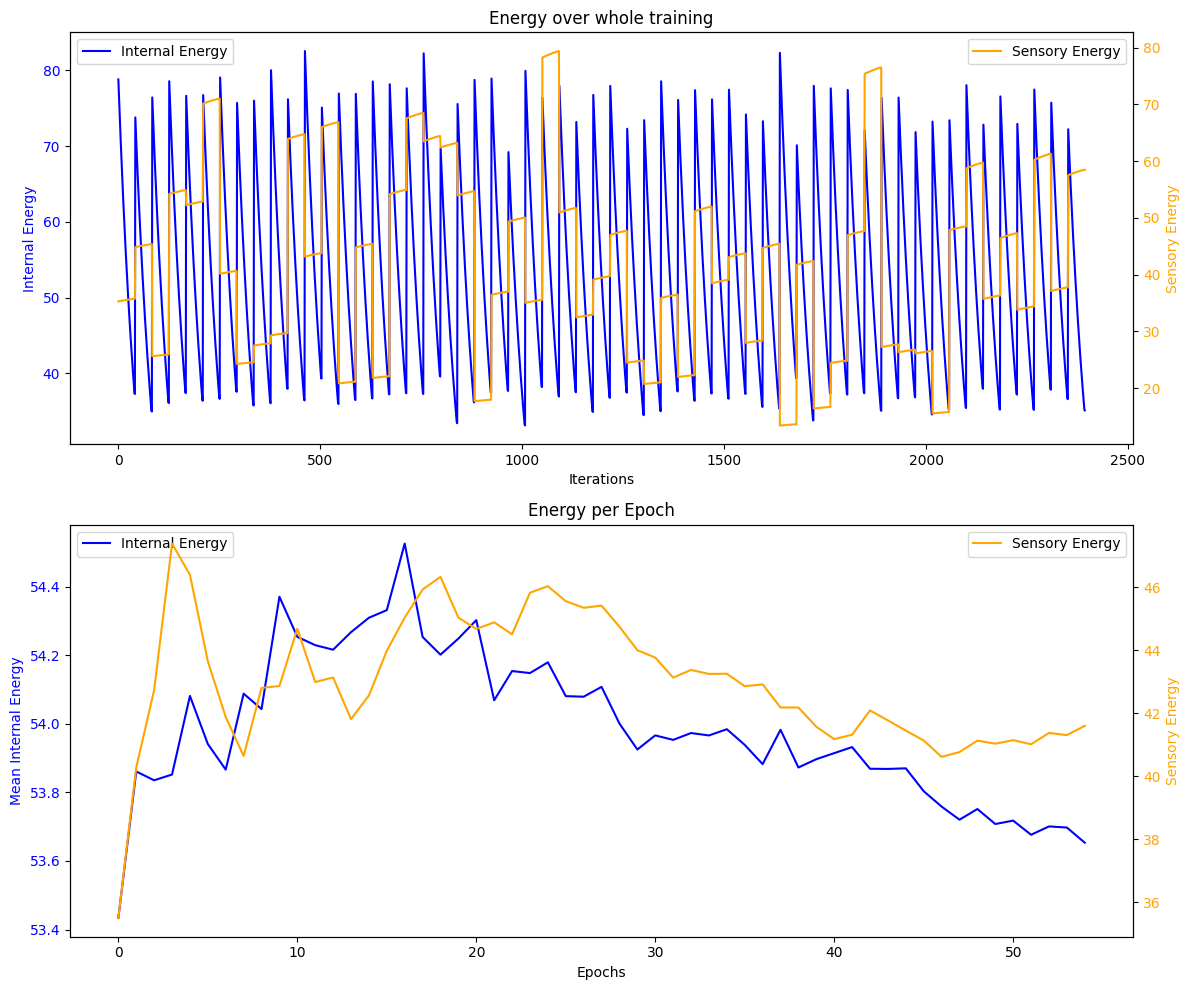

In [21]:
plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=None,
                                            epoch=epoch)


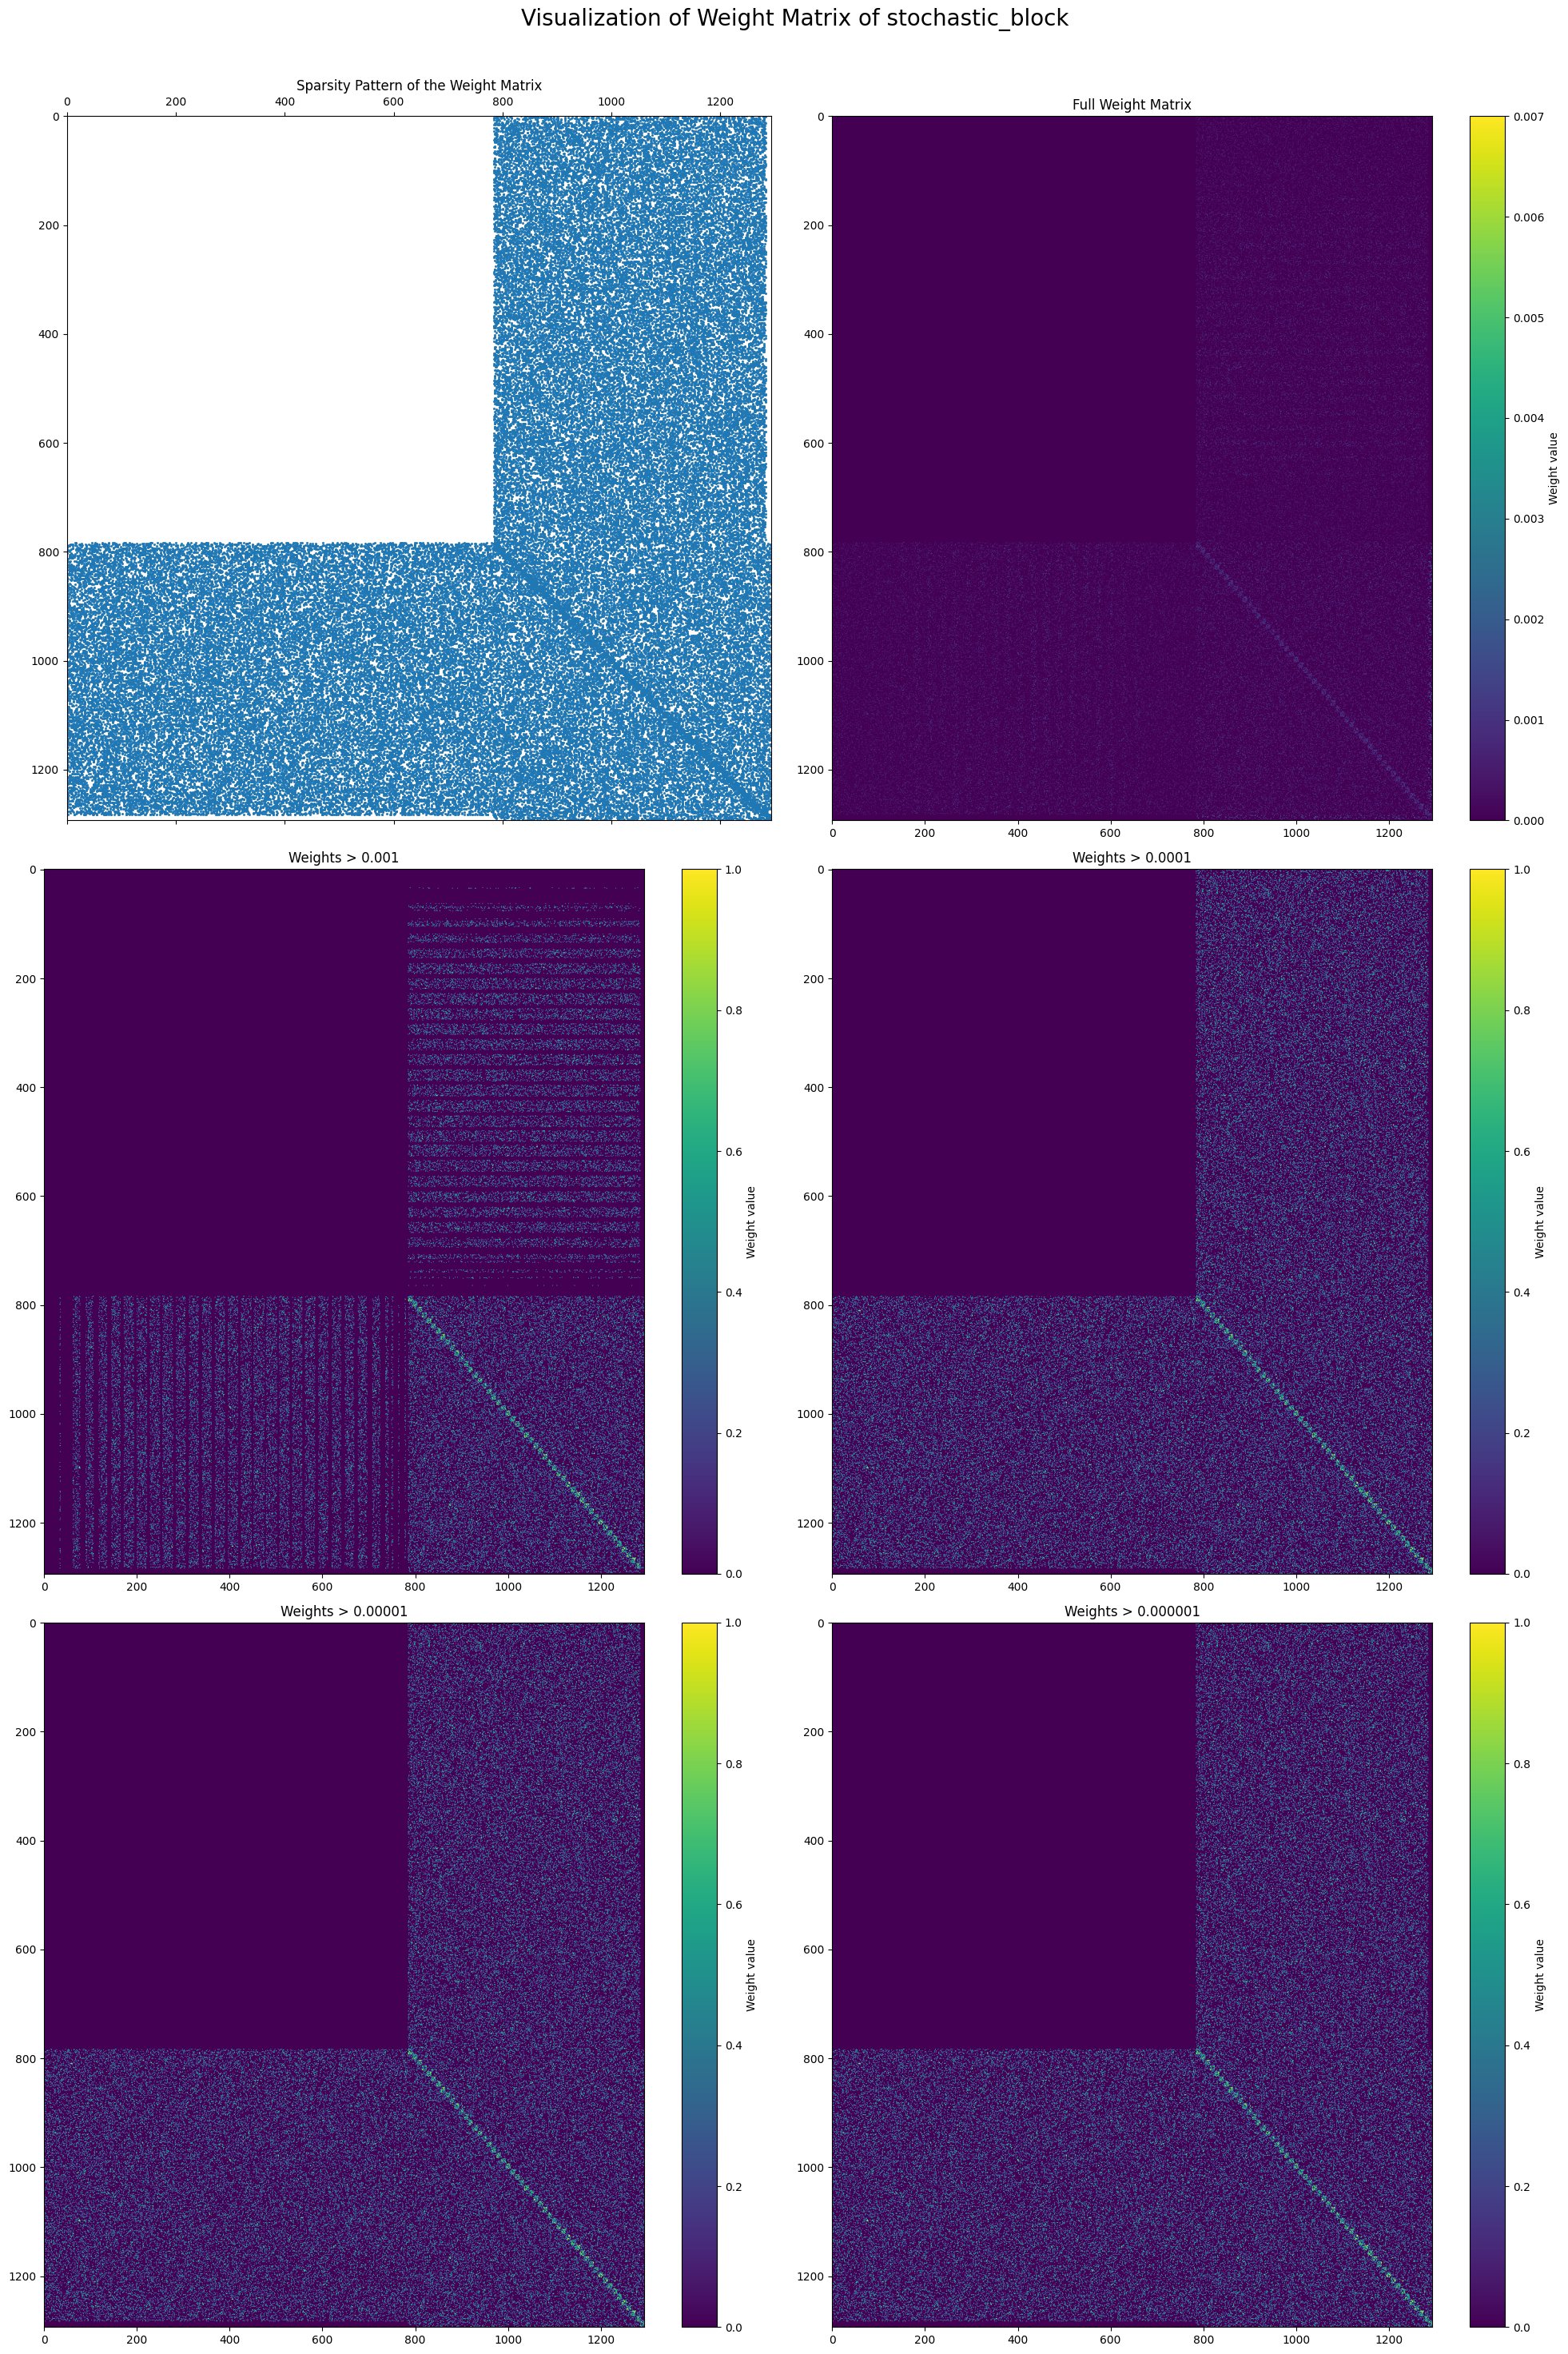

In [22]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
plot_model_weights(model, GRAPH_TYPE, model_dir=None)

In [23]:


# Save model weights 
######################################################################################################### 
####                                            Evaluation (setup)                                  #####
######################################################################################################### 
 
# device = torch.device('cpu')
from eval_tasks import classification, denoise, occlusion, generation #, reconstruction
model.pc_conv1.batchsize = 1


### Make dataloader for testing where we take all the digits of the number_list we trained on ###
dataset_params_testing = dataset_params.copy()

if "batch_size" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["batch_size"]

if "NUM_INTERNAL_NODES" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["NUM_INTERNAL_NODES"]

dataset_params_testing["edge_index"] = custom_dataset_train.edge_index

dataset_params_testing["mnist_dataset"] = mnist_testset
dataset_params_testing["N"] = "all"
dataset_params_testing["supervision_label_val"] = dataset_params["supervision_label_val"]



for key in dataset_params_testing:
    print(key, ":\t ", dataset_params_testing[key])


# CustomGraphDataset params
custom_dataset_test = CustomGraphDataset(graph_params, **dataset_params_testing, 
                                        indices=(num_vertices, sensory_indices, internal_indices, supervision_indices)
                                        )
# dataset_params_testing["batch_size"] = 2

test_loader = DataLoader(custom_dataset_test, batch_size=1, shuffle=True, generator=generator_seed)



mnist_dataset :	  Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
supervised_learning :	  True
numbers_list :	  [0, 1, 3, 4, 5, 6, 7]
same_digit :	  False
add_noise :	  False
noise_intensity :	  0.0
N :	  all
edge_index :	  tensor([[   0,    0,    0,  ..., 1293, 1293, 1293],
        [ 791,  796,  807,  ..., 1286, 1287, 1292]])
supervision_label_val :	  10
Supervised learning
Taking first n=all digits from each class
-----Done-----
1294
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 10

In [15]:
# 
# plot_model_weights(model, model_dir=None)

In [16]:
# for idx, (noisy_batch, clean_image) in enumerate(test_loader, start=1):
#     noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape

#     torch.rand(noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape).shape
#     break

In [24]:
def get_clean_images_by_label(mnist_train, num_images=10):
    """
    Extract num_images clean images for each label (0-9) from mnist_train.
    Returns a dictionary with labels as keys and a list of clean images as values.
    """
    clean_images = {label: [] for label in range(10)}

    for label in range(10):
        # Filter the indices for the current label
        class_indices = [i for i, lbl in enumerate(mnist_train.targets) if lbl == label]
        
        # Get the first num_images clean images for the current label
        clean_images[label] = [mnist_train[i][0].squeeze().numpy() for i in class_indices[:num_images]]

    return clean_images

# Example usage:
clean_images = get_clean_images_by_label(mnist_trainset, num_images=10)



In [25]:
model.trace(values=True, errors=False)

vertix 1294
before after 784 784
before after 500 500
before after 10 10
-------------mode testing--------------
-------------task classification--------------
model.pc_conv1.values.shape torch.Size([1294, 1])
AAAAAAAAAAAA
model.pc_conv1.values.shape torch.Size([1294, 1])
CHECK 1  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
No vmin vmax
Done for idx 5627
tensor([6])
torch.Size([1294, 3, 1])
CHECK 2  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
CHECK 3  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], devi

Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.99312335 -0.013463135
Denoised val 1.0 0.0
tensor([0.0180, 0.0632, 0.0097, 0.0423, 0.0607, 0.0211, 0.0523, 0.0248, 0.0113,
        0.0111], device='cuda:0')
tensor([0.0180, 0.0632, 0.0097, 0.0423, 0.0607, 0.0211, 0.0523, 0.0248, 0.0113,
        0.0111], device='cuda:0')
tensor([[0.0180],
        [0.0632],
        [0.0097],
        [0.0423],
        [0.0607],
        [0.0211],
        [0.0523],
        [0.0248],
        [0.0113],
        [0.0111]], device='cuda:0')
tensor([0.0986, 0.1032, 0.0978, 0.1011, 0.1030, 0.0989, 0.1021, 0.0993, 0.0980,
        0.0980], device='cuda:0')
tensor(1)
---------Done-----------------
TODO output y_pred and y_true to file 
[6] [1]
Classification Metrics:
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


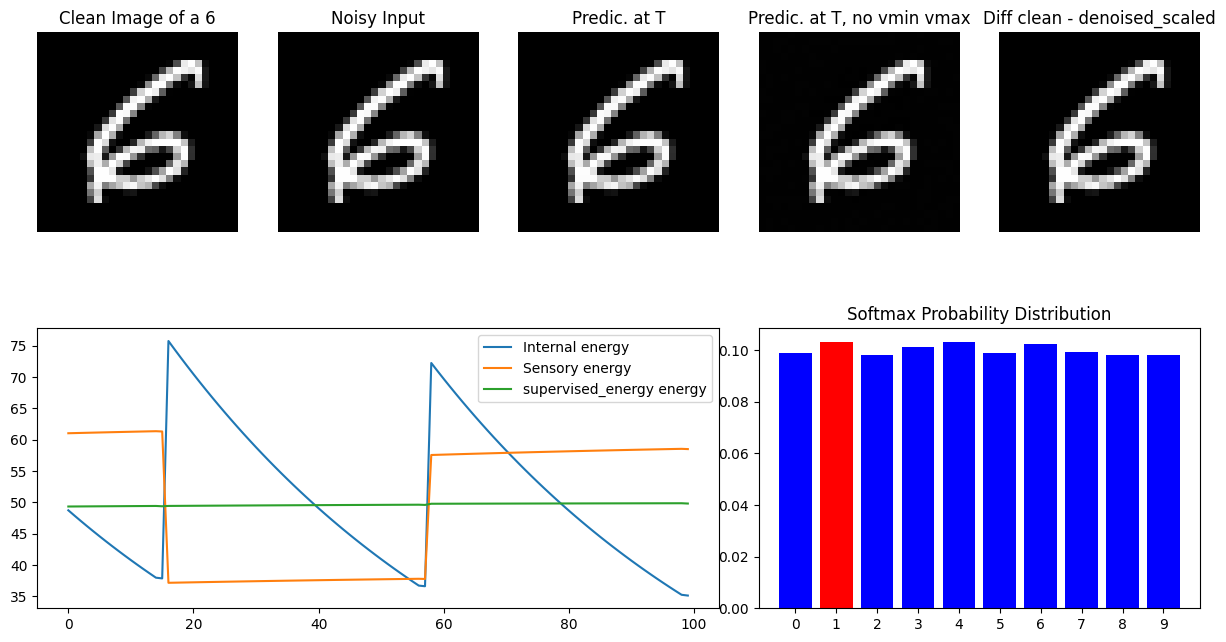

In [26]:
model.pc_conv1.trace_activity_values = True 

model.pc_conv1.batchsize = 1

test_params = {
    "model_dir": model_dir,
    "T":100,
    "supervised_learning":False, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
y_true, y_pred, accuracy_mean = classification(test_loader, model, test_params)

In [20]:
# model.enable_all_connections()

In [21]:
# # source_nodes = model.pc_conv1.edge_index[0]   # all i's 
# # target_nodes = model.pc_conv1.edge_index[1]   # all j's 

# # # Gather the corresponding errors and f_x values for each edge
# # # print("source_nodes shape", source_nodes.shape)
# # # print("errors shape", errors.shape)
# # # print("f_x shape", f_x.shape)
# # source_errors = model.pc_conv1.values[source_nodes].detach()    # get all e_i's 
# # target_fx = model.pc_conv1.values[target_nodes].detach()   

# # V = source_errors * target_fx

# V_p = V.reshape(model.pc_conv1.batchsize, model.pc_conv1.edge_index_single_graph.size(1)) 
# V_p.shape

In [27]:
# Example matrices
# matrix_list = [np.random.rand(5, 5) for _ in range(10)]  # Create 10 random 5x5 matrices

matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["values"] ] 

matrix_list = [torch.ger(i, i) for i in matrix_list]

# Create diagonal matrices from each tensor
# matrix_list = [torch.diag(i) for i in matrix_list]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a figure and axis
fig, ax = plt.subplots()

matrix_list_show = matrix_list[:20]

# Display the first matrix
im = ax.imshow(matrix_list_show[0], cmap='viridis')
cbar = plt.colorbar(im)  # Add the color bar

# Function to update the matrix in each frame
def update(frame):
    im.set_array(matrix_list_show[frame])  # Update the data for the new frame
    return [im]

# Prevent static display of imshow() after the animation
plt.close()

# Create the animation
ani = FuncAnimation(fig, update, frames=len(matrix_list_show), blit=True, interval=500)

# Display the animation in the notebook
HTML(ani.to_jshtml())

vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task classification--------------
model.pc_conv1.values.shape torch.Size([2294, 1])
AAAAAAAAAAAA
model.pc_conv1.values.shape torch.Size([2294, 1])
CHECK 1  tensor([[0.3414],
        [0.2477],
        [0.2157],
        [0.3228],
        [0.2552],
        [0.2682],
        [0.2744],
        [0.2708],
        [0.2157],
        [0.2157]], device='cuda:0')
No vmin vmax
Done for idx 1380
tensor([1])
torch.Size([2294, 3, 1])
CHECK 2  tensor([[0.3414],
        [0.2477],
        [0.2157],
        [0.3228],
        [0.2552],
        [0.2682],
        [0.2744],
        [0.2708],
        [0.2157],
        [0.2157]], device='cuda:0')
CHECK 3  tensor([[0.3414],
        [0.2477],
        [0.2157],
        [0.3228],
        [0.2552],
        [0.2682],
        [0.2744],
        [0.2708],
        [0.2157],
        [0.2157]], device='cuda:0')
labels model tensor([[0.],
        [

Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.73882127 -0.27319738
Denoised val 1.0 0.0
tensor([0.2774, 0.3920, 0.1961, 0.3672, 0.2847, 0.2466, 0.3320, 0.3912, 0.1961,
        0.1961], device='cuda:0')
tensor([0.2774, 0.3920, 0.1961, 0.3672, 0.2847, 0.2466, 0.3320, 0.3912, 0.1961,
        0.1961], device='cuda:0')
tensor([[0.2774],
        [0.3920],
        [0.1961],
        [0.3672],
        [0.2847],
        [0.2466],
        [0.3320],
        [0.3912],
        [0.1961],
        [0.1961]], device='cuda:0')
tensor([0.0987, 0.1106, 0.0910, 0.1079, 0.0994, 0.0957, 0.1042, 0.1106, 0.0910,
        0.0910], device='cuda:0')
tensor(1)
---------Done-----------------
TODO output y_pred and y_true to file 
[1] [1]
Classification Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


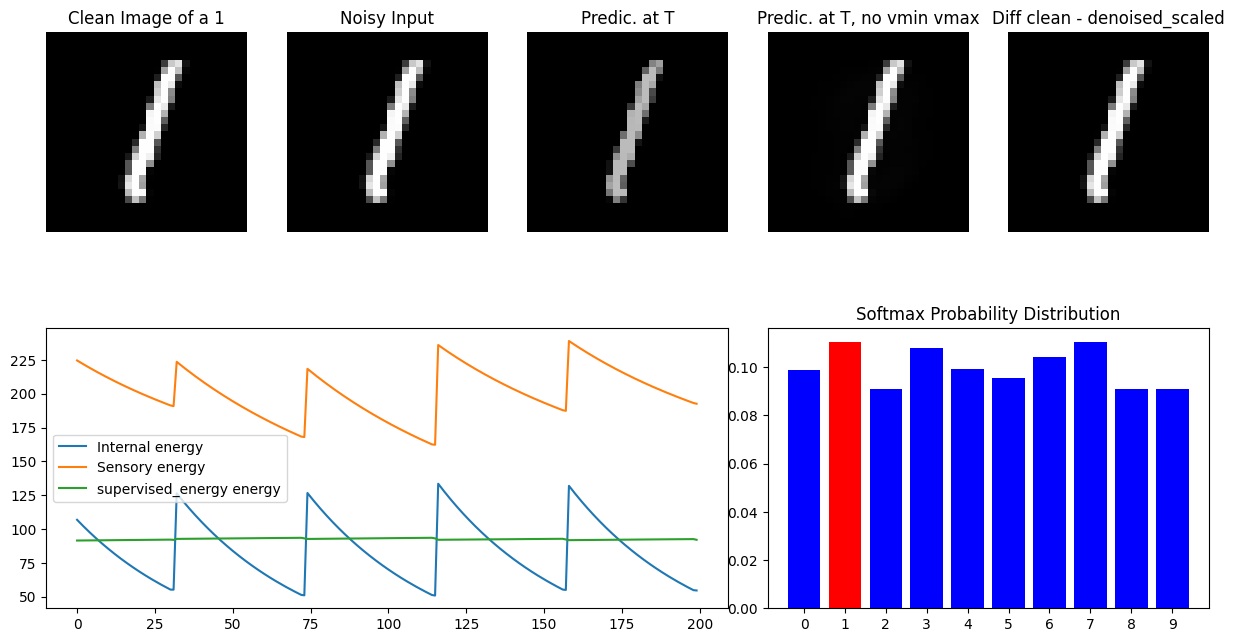

In [23]:

model.pc_conv1.batchsize = 1

test_params = {
    "model_dir": model_dir,
    "T":200,
    "supervised_learning":False, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
y_true, y_pred, accuracy_mean = classification(test_loader, model, test_params)

In [24]:


model.pc_conv1.batchsize = 1

######################################################################################################### 
####                                            Evaluation (tasks)                                  #####
######################################################################################################### 
 
test_params = {
    "model_dir": model_dir,
    "T": 300,
    "supervised_learning":True, 
    "num_samples": 5,
    "add_sens_noise": False,
}

# model.pc_conv1.lr_values = 0.1 
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_occ = occlusion(test_loader, model, test_params)

test_params["add_sens_noise"] = True
MSE_values_occ_noise = occlusion(test_loader, model, test_params)

######################################################################################################### 

######################################################################################################### 

test_params = {
    "model_dir": model_dir,
    "T": 300,
    "supervised_learning":True, 
    "num_samples": 6,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_denoise_sup = denoise(test_loader, model, test_params)

test_params["supervised_learning"] = False
MSE_values_denoise = denoise(test_loader, model, test_params)
                            
# MSE_values = denoise(test_loader, model, supervised_learning=True)
# print("MSE_values", MSE_values)
######################################################################################################### 



# # MSE_values = denoise(test_loader, model, supervised_learning=True)
# # print("MSE_values", MSE_values)


# print("accuracy_mean", accuracy_mean)

# print("model_dir", model_dir)

# # write a text file with these 


# # Open the file in write mode
# with open(model_dir + "eval/eval_scores.txt", 'w') as file:
#     # Write each list to the file

#     file.write("MSE_values_denoise_sup:\n")
#     file.write(", ".join(map(str, MSE_values_denoise_sup)) + "\n\n")

#     file.write("MSE_values_denoise:\n")
#     file.write(", ".join(map(str, MSE_values_denoise)) + "\n\n")
    
#     file.write("MSE_values_occ_noise:\n")
#     file.write(", ".join(map(str, MSE_values_occ_noise)) + "\n\n")
    
#     file.write("MSE_values_occ:\n")
#     file.write(", ".join(map(str, MSE_values_occ)) + "\n\n")

#     file.write("accuracy_mean:\n")
#     file.write("y_true: " + ", ".join(map(str, y_true)) + "\n")
#     file.write("y_pred: " + ", ".join(map(str, y_pred)) + "\n")
    
#     file.write(str(accuracy_mean) + "\n\n")


# from datetime import datetime
# # Get the current date and time
# current_datetime = datetime.now()
# # Print the current date and time
# print("Current date and time:", current_datetime)



# wandb.log({"accuracy_mean": accuracy_mean})
# # wandb.log({"energy_sensory": energy["sensory_energy"]})






# wandb.finish()

vertix 2294
before after 784 784
before after 1500 1500
before after 10 10
-------------mode testing--------------
-------------task reconstruction--------------
-------------Restarting activity (pred/errors/values)--------------
Done for idx 5960
idx 1
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS reconstruction
Pass
Aaaa torch.Size([2294, 3, 1])


KeyboardInterrupt: 

In [15]:
# model.Disable_connection(from_indices=sensory_indices, 
#                          to_indices=supervision_indices)

In [ ]:
# model.enable_all_connections()

vertix 1294
before after 784 784
before after 500 500
before after 10 10
-------------mode testing--------------
-------------task generation--------------
model.pc_conv1.values.shape torch.Size([1294, 1])
-------------Restarting activity (pred/errors/values)--------------
No vmin vmax
Done for idx 1869
tensor([1])
torch.Size([1294, 3, 1])
omitting setting sensory nodes
labels before torch.Size([10]) tensor([0.9900, 0.0000, 0.0000, 0.8644, 0.0000, 0.0000, 0.3689, 0.0000, 0.0000,
        0.7115], device='cuda:0')
labels after tensor([0.9900, 0.0000, 0.0000, 0.8644, 0.0000, 0.0000, 0.3689, 0.0000, 0.0000,
        0.7115], device='cuda:0')
tensor([[ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
labels model tensor([[ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
aaa te

Inference completed.
QUery by condition or query by init
CHECK tensor([[ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
Predic. at T, no vmin vmax 0.37411374 0.005941492
Denoised val 0.3852497 0.012299059
generation_task_1.png
CHECK tensor([[ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
ssim_values [-0.004629297633133424]
mse_values [0.09084199]
ssim_values [-0.004629297633133424, -0.001223211728734174]
mse_values [0.09084199, 0.09494871]
ssim_values [-0.004629297633133424, -0.001223211728734174, -0.01582563319104248]
mse_values [0.09084199, 0.09494871, 0.075812586]
ssim_values [-0.004629297633133424, -0.001223211728734174, -0.01582563319104248, -0.00928770532639774]
mse_values [0.09084199, 0.09494871, 0.075812586, 0.077271976]
ssim_values [-0.004629297633133424, -0

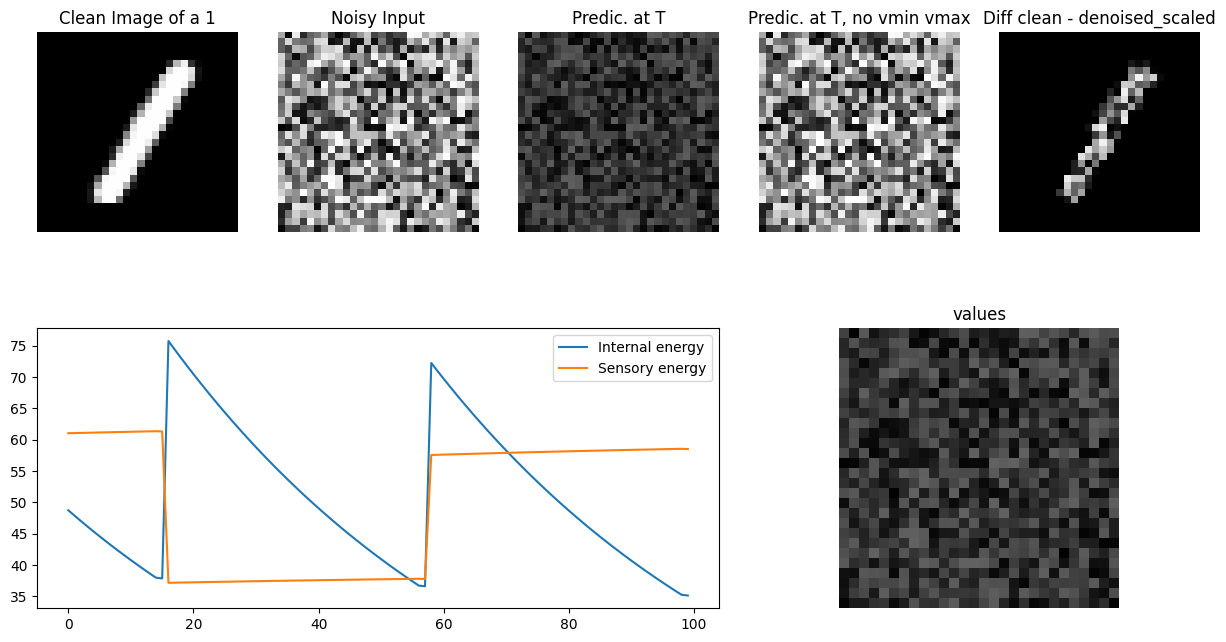

In [28]:

test_params = {
    "model_dir": model_dir,
    "T": 100,
    "supervised_learning":True, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

avg_SSIM_mean, avg_SSIM_max, avg_MSE_mean, avg_MSE_max = generation(test_loader, model, test_params, clean_images, verbose=1)
                            